## Load needed things

### Import packages

In [1]:
import numpy as np
import nltk
import pandas as pd
import xml.etree.ElementTree as ET
from collections import namedtuple
from os import listdir
from os.path import isfile, join
import re
import string
from typing import Callable, List
from spellchecker import SpellChecker
import json
from tqdm import tqdm
import spacy
import ftfy
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from polyglot.text import Text
from mtranslate import translate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import mutual_info_classif

%matplotlib inline
tqdm.pandas()

### Define needed variables

In [2]:
tweet = namedtuple('Tweet', ['tweetid', 'content', 'polarity'])
stopWords = set(nltk.corpus.stopwords.words('spanish'))
nlp = spacy.load('es')
spell = SpellChecker(language='es')

## Preprocessing

### Read data

In [3]:
def read_data(file: str) -> pd.DataFrame:
    """Read data from given file and return it as a dataframe."""
    tweets: List = []
    with open(file, 'r') as f:
        tree = ET.parse(file)
        root = tree.getroot()
        for child in root:
            tweets.append(tweet(child[0].text, child[2].text, child[5][0][0].text))
    return pd.DataFrame(tweets)

def read_folder(folder: str) -> pd.DataFrame:
    """
    Read data from given folder, combines the training and dev set
    and return them combined as a dataframe.
    """
    dataframes = []
    files = [f for f in listdir(folder) if isfile(join(folder, f))]
    for file in files:
        if 'xml' in file:
            dataframes.append(read_data(folder + file))
    return pd.concat(dataframes)

### String manipulation

Don't need to care for emoticons, because there are less than 10.

In [4]:
def remove_mention(tweet: str) -> str:
    return re.sub(r'@[A-Za-z0-9]+', '', tweet)

def lower_case(tweet: str) -> str:
    """Turn a tweet to lower case."""
    return tweet.lower()

def remove_question_mark(tweet: str) -> str:
    """Remove spanish question mark from a tweet."""
    return tweet.replace('¿', '')

def remove_punctuation(tweet: str) -> str:
    """Remove punctuation from a tweet."""
    return tweet.translate(str.maketrans('', '', string.punctuation))

def remove_whitespace(tweet: str) -> str:
    return tweet.strip()

def check_int(s):
    if s[0] in ('-', '+'):
        return s[1:].isdigit()
    return s.isdigit()

def remove_numbers(tweet: str) -> str:
    """Remove numbers from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if not check_int(word)])

def fix_encoding(tweet: str) -> str:
    return ftfy.fix_encoding(tweet)

def fix_repeated_letters(tweet: str) -> str:
    """Replace repeated characters (3 repetitions or more) with only two characters."""
    return re.sub(r'(.)\1+', r'\1\1', tweet)

def fix_spelling(tweet: str) -> str:
    """Fix spelling error in tweets."""
    tokenized = nltk.word_tokenize(tweet)
    misspelled = spell.unknown(tokenized)
    for i in range(len(tokenized)):
        if tokenized[i] in misspelled:
            tokenized[i] = spell.correction(tokenized[i])
    return ' '.join(tokenized)

def clean_tweet(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 remove_mention,
                 lower_case,
                 remove_question_mark,
                 remove_punctuation,
                 remove_numbers,
                 remove_whitespace,
                 fix_repeated_letters,
                 fix_encoding,
                 fix_spelling
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

### Spelling
Preprocessing that should be done after spell correction.

In [5]:
def remove_stopwords(tweet: str) -> str:
    """Remove stopwords from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if word not in stopWords])

def stem_tweet(tweet: str) -> str:
    tweet = nlp(tweet)
    return ' '.join([token.lemma_ for token in tweet])


def clean_tweet2(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 stem_tweet
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

In [98]:
def augment_data(df):
    new_trans = 2
    new_df = df.copy()
    new_df['augmented'] = 0
    new_df['from_lang'] = 'none'
    for index, row in tqdm(new_df.iterrows()):
        new_df = add_row(new_df, row, 'en')
        
        if row['polarity'] == 'NONE' or row['polarity'] == 'NEU':
            new_df = add_row(new_df, row, 'fr')
        
    return new_df

def add_row(dataf, old_row, lang):
    trans = translate(translate(old_row['content'], lang, 'es'), 'es', lang)
    row = {'tweetid': old_row['tweetid'],
                      'content': trans,
                      'polarity': old_row['polarity'],
                      'augmented': 1,
                      'from_lang': lang}
    dataf = dataf.append(row, ignore_index=True)
    return dataf

### Clean and save

In [ ]:
df = read_data("data/cr/intertass_cr_train.xml")
df['content'] = df['content'].progress_apply(clean_tweet)
df.to_csv("data/cr/cleaned.csv", index=False)

In [99]:
df = pd.read_csv("data/cr/cleaned.csv")
df = augment_data(df)
df.to_csv("data/cr/cleaned_augmented.csv", index=False)

777it [08:30,  1.37it/s]


In [100]:
df = pd.read_csv("data/cr/cleaned_augmented.csv")
df['content'] = df['content'].progress_apply(clean_tweet2)
df = df.drop_duplicates('content', keep='first')
df.to_csv("data/cr/cleaned_augmented_complete.csv")

100%|██████████| 1800/1800 [00:11<00:00, 157.31it/s]


In [101]:
df = pd.read_csv("data/cr/cleaned_augmented_complete.csv")

## Explore data

### Load data from file

In [ ]:
df.head()

In [ ]:
df.tail()

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 6 columns):
Unnamed: 0    1725 non-null int64
tweetid       1725 non-null int64
content       1725 non-null object
polarity      1725 non-null object
augmented     1725 non-null int64
from_lang     1725 non-null object
dtypes: int64(3), object(3)
memory usage: 80.9+ KB


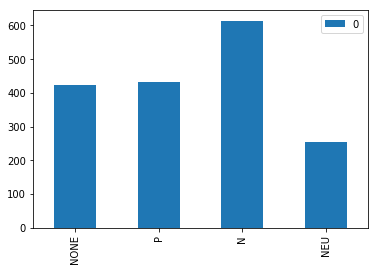

In [103]:
polarity_counts = Counter(df.polarity.values)
plotdf = pd.DataFrame.from_dict(polarity_counts, orient='index')
plotdf.plot(kind='bar')

## Classifier

### Turn tweets into features

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [12]:
class PolarityExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def transform(self, X, y=None):
        return [self.get_feature(tweet) for tweet in X]
    
    def get_feature(self, tweet: str):
        text = Text(tweet)
        text.language = 'es'
        features = []
        
        features.append(sum([1 for w in text.words if w.polarity > 0]) / len(text.words))
        features.append(sum([1 for w in text.words if w.polarity == 0]) / len(text.words))
        features.append(sum([1 for w in text.words if w.polarity < 0]) / len(text.words))
        return features
    
    def fit(self, X, y=None):
        return self  # generally does nothing

### Classify the tweets

In [104]:
df_train = df
df_test = pd.read_csv("data/cr/test_cleaned.csv")

In [105]:
le = preprocessing.LabelEncoder()
le.fit(df.polarity)

LabelEncoder()

In [253]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

vect = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2))),
                     ('latent', TruncatedSVD(n_components=100, random_state=0)),])

polarity = Pipeline([('polarity', PolarityExtractor())])

tfidf = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1, 2))),
                    ('latent', TruncatedSVD(n_components=600, random_state=0)),])

kmeans_vect = Pipeline([("vect", CountVectorizer(ngram_range=(1, 4))),
                     ('latent', TruncatedSVD(n_components=500, random_state=0)),
                     ('kmeans', KMeans(n_clusters=4, random_state=0, n_jobs=-1))])

kmeans_tfidf = Pipeline([("tfidf", TfidfVectorizer()),
                     ('latent', TruncatedSVD(n_components=600, random_state=0)),
                     ('kmeans', KMeans(n_clusters=4, random_state=0, n_jobs=-1))])

text_clf = Pipeline([
    ('features', FeatureUnion([
        ("vect", vect),
        ('polarity', polarity),
        ('tfidf', tfidf),
        ('kmeans_vect', kmeans_vect),
        ('kmeans_tfidf', kmeans_tfidf),
    ])),
    ('clf', LinearSVC()),
])

/home/yanzheb/.local/share/virtualenvs/TASS-2019-ZSQ9DPWS/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5564102564102564
Normalized confusion matrix


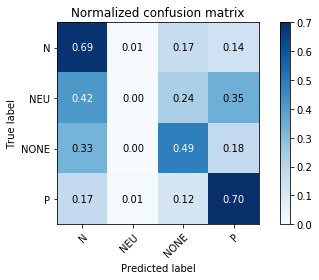

In [254]:
text_clf.fit(df_train.content, le.transform(df_train.polarity))
predicted = text_clf.predict(df_test.content)

print(np.mean(predicted == le.transform(df_test.polarity)))
plot_confusion_matrix(le.transform(df_test.polarity), predicted, le.classes_, True)

In [262]:
save_df = pd.DataFrame(data={'tweetid': df_test.tweetid, 'prediction': le.inverse_transform(predicted)})
save_df.to_csv("data/cr/cr.tsv", header=False, index=False, sep='\t')
%run evaluate.py "/home/yanzheb/projects/TASS-2019/data/cr/cr.tsv" "/home/yanzheb/projects/TASS-2019/data/cr/intertass_cr_dev_gold.tsv"

f1_score: 0.433444

precision: 0.403746

recall: 0.467856

accuracy: 0.556410

